# Random Forest

Neden Random Forest ?
* Non-Linearty : Doğrusal olmayan ilişkileri yakalama
* Overfitting riskinin azalması : Her bir karar ağacı, veri setinin rastgele seçilmiş bir alt kümesi üzerinde eğitilir.
* Feature Importance Belirleme : Enerji tüketimini en çok etkileyen faktörlerin hangileri olduğunu doğrulayabilir.

In [106]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [107]:
df = pd.read_csv('final_training_data.csv')
df.head(3)

,timestamp,vehicle_id,speed_kmh,lat,lon,z,acceleration,mass_kg,soc_pc,energy_consumption,...,device.battery.maximumChargeRate,recuperationEfficiency,rollDragCoefficient,constantPowerIntake,rotatingMass,airDragCoefficient,maximumPower,propulsionEfficiency,dist_m,slope_pct
0,2,veh1,0.000,39.749175,30.508940,822.0,0.00,1958.0,96.554181,0.00,...,144211.0,0.94,0.01,484.0,39.0,0.344,193684.0,0.94,NaN,NaN
1,3,veh1,14.112,39.749195,30.508903,822.0,3.92,1958.0,96.549121,4.90,...,144211.0,0.94,0.01,484.0,39.0,0.344,193684.0,0.94,3.914897,0.0
2,4,veh1,28.224,39.749237,30.508829,822.0,3.92,1958.0,96.534407,14.25,...,144211.0,0.94,0.01,484.0,39.0,0.344,193684.0,0.94,7.829794,0.0


In [108]:
print("Orijinal veri boyutu:", df.shape)
print("Araç sayısı:", df['vehicle_id'].nunique())
print("Eksik veri durumu:")
print(df.isnull().sum())

Orijinal veri boyutu: (167210, 25)
Araç sayısı: 1500
Eksik veri durumu:
timestamp                               0
vehicle_id                              0
speed_kmh                               0
lat                                     0
lon                                     0
z                                       0
acceleration                            0
mass_kg                                 0
soc_pc                                  0
energy_consumption                      0
accel                                   0
decel                                   0
radialDragCoefficient                   0
frontSurfaceArea                        0
device.battery.capacity                 0
device.battery.maximumChargeRate        0
recuperationEfficiency                  0
rollDragCoefficient                     0
constantPowerIntake                     0
rotatingMass                            0
airDragCoefficient                      0
maximumPower                            0
prop

In [109]:
# 'dist_m' sütunundaki NaN değerleri 0 ile doldurur
df['dist_m'] = df['dist_m'].fillna(0)

# 'slope_pct' sütunundaki NaN değerleri 0 ile doldurur
df['slope_pct'] = df['slope_pct'].fillna(0)

In [111]:
print(df.isnull().sum())

timestamp                           0
vehicle_id                          0
speed_kmh                           0
lat                                 0
lon                                 0
z                                   0
acceleration                        0
mass_kg                             0
soc_pc                              0
energy_consumption                  0
accel                               0
decel                               0
radialDragCoefficient               0
frontSurfaceArea                    0
device.battery.capacity             0
device.battery.maximumChargeRate    0
recuperationEfficiency              0
rollDragCoefficient                 0
constantPowerIntake                 0
rotatingMass                        0
airDragCoefficient                  0
maximumPower                        0
propulsionEfficiency                0
dist_m                              0
slope_pct                           0
dtype: int64


In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167210 entries, 0 to 167209
Data columns (total 25 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   timestamp                         167210 non-null  int64  
 1   vehicle_id                        167210 non-null  object 
 2   speed_kmh                         167210 non-null  float64
 3   lat                               167210 non-null  float64
 4   lon                               167210 non-null  float64
 5   z                                 167210 non-null  float64
 6   acceleration                      167210 non-null  float64
 7   mass_kg                           167210 non-null  float64
 8   soc_pc                            167210 non-null  float64
 9   energy_consumption                167210 non-null  float64
 10  accel                             167210 non-null  float64
 11  decel                             167210 non-null  f

In [112]:
# ivme ayrımı
# bu sayede enerji tüketimi (hızlanırken) ve rejeneratif enerji kazanımı (yavaşlarken) ayrı ayrı analiz edilebilir.
# verimlilik hesaplarını ve optimizasyonu daha doğru yapmayı sağlar
# Pozitif ivme (gaz) tüketimi artırır; negatif ivme (fren/iniş) rejenerasyon sağlayabilir. Tek sütun olsa bu fark kaybolabilirdi
df["acc_pos"] = df["acceleration"].clip(lower=0)
df["acc_neg"] = (-df["acceleration"]).clip(lower=0)

In [113]:
# Hız: m/s ve v^2
df["speed_ms"] = df["speed_kmh"] / 3.6

# Aerodinamik: Cd * A
df["CdA"] = df["airDragCoefficient"] * df["frontSurfaceArea"] # bu ikini birleştirip vermek daha mantıklı

#df["target_Wh_per_km"] = df["energy_consumption"] / (df["dist_m"] / 1000.0)

In [114]:
columns_to_drop = [
    'timestamp',  # Zaman bilgisi
    'lat', 'lon', 'z',  # GPS koordinatları
    'accel','decel', 'acceleration',
    'speed_kmh',
    'device.battery.capacity',
    'airDragCoefficient', 'frontSurfaceArea',

]
df = df.drop(columns=columns_to_drop)

In [115]:
df.shape

(167210, 18)

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167210 entries, 0 to 167209
Data columns (total 18 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   vehicle_id                        167210 non-null  object 
 1   mass_kg                           167210 non-null  float64
 2   soc_pc                            167210 non-null  float64
 3   energy_consumption                167210 non-null  float64
 4   radialDragCoefficient             167210 non-null  float64
 5   device.battery.maximumChargeRate  167210 non-null  float64
 6   recuperationEfficiency            167210 non-null  float64
 7   rollDragCoefficient               167210 non-null  float64
 8   constantPowerIntake               167210 non-null  float64
 9   rotatingMass                      167210 non-null  float64
 10  maximumPower                      167210 non-null  float64
 11  propulsionEfficiency              167210 non-null  f

In [117]:
# aynı araca ait satırların train/val/test’e karışmamasını sağlar. Yani vehicle_id bazlı ayırır; veri sızıntısını (leakage) önler.
from sklearn.model_selection import GroupShuffleSplit

groups = df["vehicle_id"]

X = df.drop(columns=[ "vehicle_id", "energy_consumption"])
y = df["energy_consumption"]


# GroupShuffleSplit ile önce test setini ayırıyor. Bu aşamada bir araca ait tüm satırlar ya testte ya da train+val tarafında kalır; asla bölünmez.
def group_split(X, y, groups, test_size=0.15, val_size=0.15, rs=42):
    """
    X, y ve groups'u alır; önce TEST setini, sonra kalan içinden VALIDATION setini ayırır.
    NOT: Aynı 'vehicle_id'ye ait TÜM satırlar ya train/val tarafında kalır ya da testte olur;
         asla bir araca ait satırlar birden fazla parçaya bölünmez.
    """
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=rs)
    i_tr, i_te = next(gss.split(X, y, groups))
    gss2 = GroupShuffleSplit(n_splits=1, test_size=val_size/(1-test_size), random_state=rs)
    j_tr, j_val = next(gss2.split(X.iloc[i_tr], y.iloc[i_tr], groups.iloc[i_tr]))
    tr_idx = X.iloc[i_tr].index[j_tr]; val_idx = X.iloc[i_tr].index[j_val]; te_idx = X.index[i_te]
    return tr_idx, val_idx, te_idx

train_idx, val_idx, test_idx = group_split(X, y, groups)
X_train, y_train = X.loc[train_idx], y.loc[train_idx]
X_val,   y_val   = X.loc[val_idx],   y.loc[val_idx]
X_test,  y_test  = X.loc[test_idx],  y.loc[test_idx]
print(f"Split -> train:{len(train_idx)}, val:{len(val_idx)}, test:{len(test_idx)}")


Split -> train:117819, val:24728, test:24663


In [118]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167210 entries, 0 to 167209
Data columns (total 16 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   mass_kg                           167210 non-null  float64
 1   soc_pc                            167210 non-null  float64
 2   radialDragCoefficient             167210 non-null  float64
 3   device.battery.maximumChargeRate  167210 non-null  float64
 4   recuperationEfficiency            167210 non-null  float64
 5   rollDragCoefficient               167210 non-null  float64
 6   constantPowerIntake               167210 non-null  float64
 7   rotatingMass                      167210 non-null  float64
 8   maximumPower                      167210 non-null  float64
 9   propulsionEfficiency              167210 non-null  float64
 10  dist_m                            167210 non-null  float64
 11  slope_pct                         167210 non-null  f

In [119]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error,  r2_score

In [120]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)# n_estimators: Ormandaki ağaç sayısı
print("\nRandom Forest modeli eğitiliyor...")
rf_model.fit(X_train, y_train)
print("Model eğitimi tamamlandı.")



Random Forest modeli eğitiliyor...
Model eğitimi tamamlandı.


In [121]:
# Validation ve Test tahminleri
y_val_pred = rf_model.predict(X_val)
y_test_pred = rf_model.predict(X_test)

In [122]:
# --- MSE ve RMSE ---
mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(y_val, y_val_pred)


mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)



In [123]:
print(f"Validation -> MSE: {mse_val:.4f} | RMSE: {rmse_val:.4f} | R²: {r2_val:.4f}")
print(f"Test       -> MSE: {mse_test:.4f} | RMSE: {rmse_test:.4f} | R²: {r2_test:.4f}")

Validation -> MSE: 25.1371 | RMSE: 5.0137 | R²: 0.8314
Test       -> MSE: 22.8644 | RMSE: 4.7817 | R²: 0.8593



--- Özellik Önem Dereceleri ---
acc_pos                             0.505717
acc_neg                             0.300849
dist_m                              0.107111
speed_ms                            0.050284
slope_pct                           0.011939
soc_pc                              0.007997
CdA                                 0.001894
constantPowerIntake                 0.001891
recuperationEfficiency              0.001879
rotatingMass                        0.001870
maximumPower                        0.001852
device.battery.maximumChargeRate    0.001831
radialDragCoefficient               0.001592
mass_kg                             0.001574
propulsionEfficiency                0.001278
rollDragCoefficient                 0.000440
dtype: float64


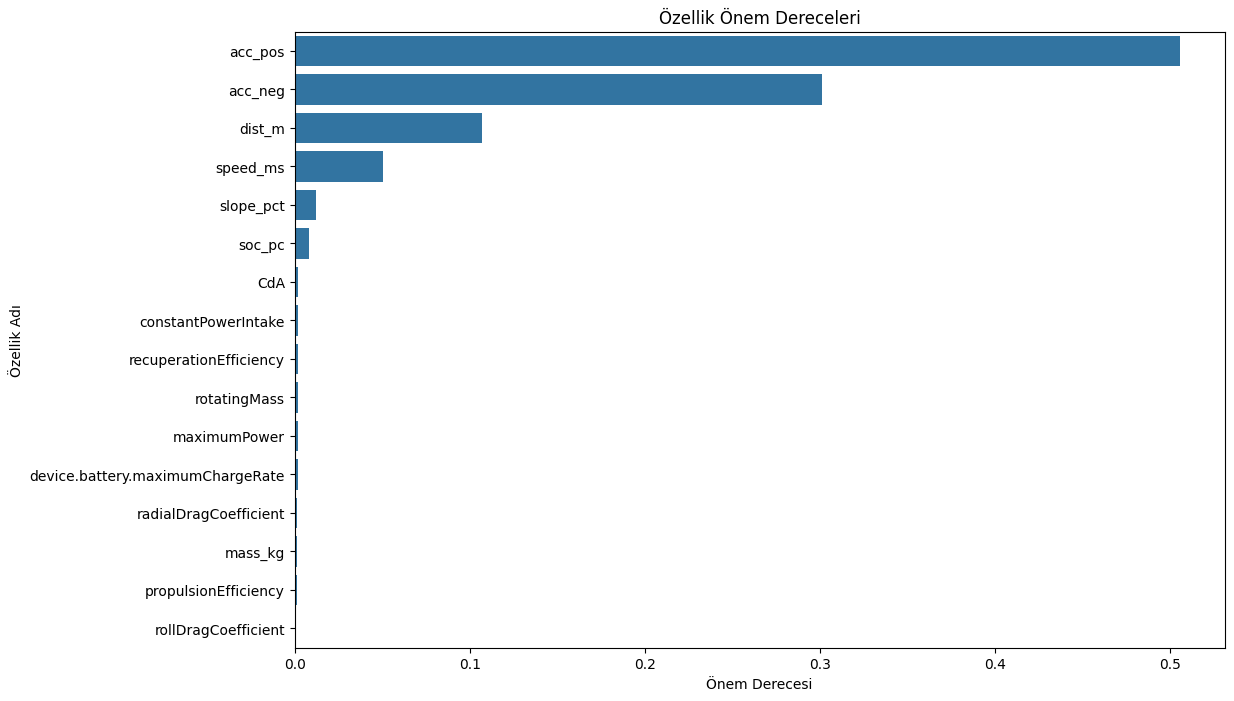

In [125]:
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

print("\n--- Özellik Önem Dereceleri ---")
print(feature_importances)

# Özellik önem derecelerini görselleştirme
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Özellik Önem Dereceleri')
plt.xlabel('Önem Derecesi')
plt.ylabel('Özellik Adı')
plt.show()

In [126]:
from sklearn.model_selection import RandomizedSearchCV

# Random Forest için ayarlanacak hiperparametrelerin aralıklarını belirleme
param_grid = {
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Randomized Search ile en iyi hiperparametreleri bulma
# n_iter: Denenecek farklı parametre kombinasyonu sayısı
# cv: K-katlı çapraz doğrulama sayısı
rf_random = RandomizedSearchCV(estimator=RandomForestRegressor(n_estimators=100,random_state=42),
                               param_distributions=param_grid,
                               n_iter=50,
                               cv=3,
                               scoring='neg_mean_squared_error',
                               verbose=2,
                               random_state=42,
                               n_jobs=-1)



In [ ]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [ ]:
print("\nEn iyi parametreler:", rf_random.best_params_)

In [ ]:
best_rf_model = rf_random.best_estimator_

y_val_pred = best_rf_model.predict(X_val)
y_test_pred = best_rf_model.predict(X_test)

In [ ]:
# --- MSE ve RMSE ---
mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(y_val, y_val_pred)


mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)


In [ ]:
print(f"Validation -> MSE: {mse_val:.4f} | RMSE: {rmse_val:.4f} | R²: {r2_val:.4f}")
print(f"Test       -> MSE: {mse_test:.4f} | RMSE: {rmse_test:.4f} | R²: {r2_test:.4f}")